**MODELO SVM PARA ANÁLISIS DE SENTIMIENTOS A PARTIR DE COMENTARIOS**

**Fase 1: Importación de Librerías**


In [ ]:
# Importación de librerías
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pickle  # Para guardar y cargar el modelo
import seaborn as sns
import matplotlib.pyplot as plt

**Fase 2: Carga y Filtrado del Dataset**


In [ ]:
# Cargar datos
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")
dev_df = pd.read_csv("/content/validation.csv")

# Filtrar solo español e inglés
target_languages = ['en', 'es']  # Inglés y español
train_df = train_df[train_df['language'].isin(target_languages)]
test_df = test_df[test_df['language'].isin(target_languages)]
dev_df = dev_df[dev_df['language'].isin(target_languages)]

# Reducir el tamaño del dataset con muestreo estratificado
new_total_size = 84000
train_size = int(new_total_size * 0.70)
dev_size = int(new_total_size * 0.20)
test_size = int(new_total_size * 0.10)

def stratified_sample(df, target_col, sample_size):
    return df.groupby(target_col, group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), int(sample_size * len(x) / len(df))), random_state=42)
    )

train_subset = stratified_sample(train_df, target_col='stars', sample_size=train_size)
dev_subset = stratified_sample(dev_df, target_col='stars', sample_size=dev_size)
test_subset = stratified_sample(test_df, target_col='stars', sample_size=test_size)

# Combinar los conjuntos de datos
data = pd.concat([train_subset, dev_subset, test_subset])

<ipython-input-3-cfdcbce3586e>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(target_col, group_keys=False).apply(
<ipython-input-3-cfdcbce3586e>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(target_col, group_keys=False).apply(
<ipython-input-3-cfdcbce3586e>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecate

**Fase 3: Preprocesamiento de Texto**


In [ ]:
# Preprocesamiento de texto
data['review_body'] = data['review_body'].str.lower().str.replace('[^\w\s]', '')
# Convertir a minúsculas y eliminar caracteres especiales

**Fase 4: Conversión de Estrellas a Polaridad**
Convertimos las calificaciones de estrellas (1-5) en tres categorías de polaridad: negativo (0), neutral (1) y positivo (2).



In [ ]:
# Función para convertir estrellas a polaridad
def convert_to_polarity(stars):
    if stars in [1, 2]:
        return 0  # Negativo
    elif stars == 3:
        return 1  # Neutral
    elif stars in [4, 5]:
        return 2  # Positivo

# Aplicar la conversión
data['polarity'] = data['stars'].apply(convert_to_polarity)

**Fase 5: División del Dataset en Train y Test**



In [ ]:
# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(data['review_body'], data['polarity'], test_size=0.2, random_state=42)

**Fase 6: Creación y Entrenamiento del Modelo + Evaluación Rendimiento**



--- Reporte de Evaluación del Modelo SVM ---
Accuracy: 0.7035
Precision: 0.6822
Recall: 0.7035
F1 Score: 0.6883

Reporte de clasificación detallado:

              precision    recall  f1-score   support

           0       0.71      0.81      0.76      6059
           1       0.43      0.28      0.34      3128
           2       0.78      0.81      0.79      6252

    accuracy                           0.70     15439
   macro avg       0.64      0.63      0.63     15439
weighted avg       0.68      0.70      0.69     15439



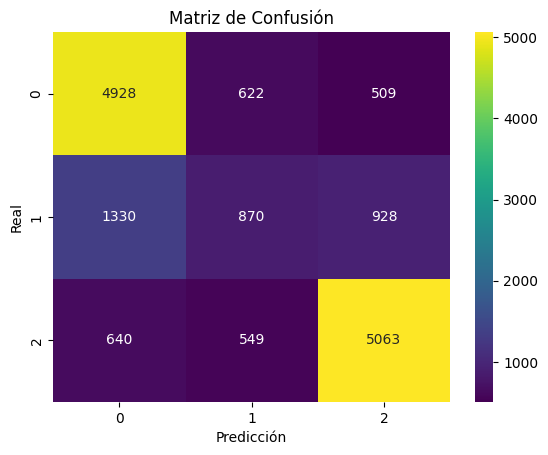

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convertir los textos a vectores numéricos
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 1))
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Entrenar el modelo SVM directamente
svm_model = SVC(C=100, gamma='scale')
svm_model.fit(X_train_vect, y_train)

# Evaluar el modelo en el conjunto de prueba
y_pred = svm_model.predict(X_test_vect)

# Métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Reporte detallado
print("\n--- Reporte de Evaluación del Modelo SVM ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nReporte de clasificación detallado:\n")
print(classification_report(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

**Fase 7: Guardado del Modelo Entrenado**

In [ ]:
import pickle

# Guardar el modelo SVM entrenado
with open('modelo_svm.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

# Guardar el vectorizador entrenado
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

**Fase 8: Carga y Uso del Modelo Guardado**

In [ ]:
import pickle
import re

# Cargar el modelo SVM entrenado
with open('modelo_svm.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Cargar el vectorizador entrenado
with open('vectorizer.pkl', 'rb') as f:
    loaded_vectorizer = pickle.load(f)

# Función para predecir la polaridad de un nuevo texto
def predecir_polaridad(texto):
    # Preprocesar el texto igual que antes
    texto_limpio = re.sub(r'[^\w\s]', '', texto.lower())

    # Transformar el texto con el mismo vectorizador entrenado
    texto_vectorizado = loaded_vectorizer.transform([texto_limpio])

    # Hacer la predicción con el modelo SVM
    polaridad = loaded_model.predict(texto_vectorizado)

    return polaridad[0]

# Ejemplo de predicción
nuevo_texto = "I feel really sad about what happened."
prediccion = predecir_polaridad(nuevo_texto)
print(f"Predicción de polaridad: {prediccion}")

Predicción de polaridad: 0
